In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Google Colab - importer les données depuis Kaggle

# Uploader clé API Kaggle (fichier kaggle.json)
from google.colab import files
files.upload()  # Sélectionne ton fichier kaggle.json téléchargé depuis Kaggle

# Configurer l'accès API Kaggle
import os
os.makedirs("/root/.kaggle", exist_ok=True)
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

# Télécharger tes datasets Kaggle (remplacé avec les tiens)
!kaggle datasets download -d ayamokhta/product-text
!kaggle datasets download -d ayamokhta/bert-multilingual
!kaggle datasets download -d ayamokhta/nlp-dl-images

# Dézipper les fichiers téléchargés
import zipfile

with zipfile.ZipFile("product-text.zip", 'r') as zip_ref:
    zip_ref.extractall("rakuten_data/product_text")

with zipfile.ZipFile("bert-multilingual.zip", 'r') as zip_ref:
    zip_ref.extractall("rakuten_data/bert_multilingual")

with zipfile.ZipFile("nlp-dl-images.zip", 'r') as zip_ref:
    zip_ref.extractall("rakuten_data/nlp_dl_images")

# Vérifier que les fichiers sont bien là
import os
print("📁 Fichiers dans product-text :", os.listdir("rakuten_data/product_text"))
print("📁 Fichiers dans bert-multilingual :", os.listdir("rakuten_data/bert_multilingual"))
print("📁 Dossiers d'images :", os.listdir("rakuten_data/nlp_dl_images"))

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/ayamokhta/product-text
License(s): unknown
Dataset URL: https://www.kaggle.com/datasets/ayamokhta/bert-multilingual
License(s): unknown
Dataset URL: https://www.kaggle.com/datasets/ayamokhta/nlp-dl-images
License(s): unknown
📁 Fichiers dans product-text : ['X_train_update.csv', 'X_test_update.csv', 'Y_train_CVw08PX.csv']
📁 Fichiers dans bert-multilingual : ['bert-multilingual-cased']
📁 Dossiers d'images : ['image_test', 'image_train']


****Le fichier X_test était prévu pour des prédictions finales dans un contexte de compétition, mais comme les vraies cibles ne sont pas fournies, il n’est pas utilisé pour l’évaluation dans ce projet.****

In [4]:
import pandas as pd
import os
import seaborn as sns
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score

import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import nltk
nltk.download('stopwords')
import re
from nltk.corpus import stopwords
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import f1_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import nltk
from nltk.corpus import stopwords

In [5]:
# Chargement des CSV
x_train = pd.read_csv("rakuten_data/product_text/X_train_update.csv")
y_train = pd.read_csv("rakuten_data/product_text/Y_train_CVw08PX.csv")
# x_test = pd.read_csv("rakuten_data/product_text/X_test_update.csv")

print("x_train :", x_train.shape)
print("y_train :", y_train.shape)
#rint("x_test  :", x_test.shape)

x_train : (84916, 5)
y_train : (84916, 2)


In [6]:
# Supprimer la colonne d’index inutile
y_train = y_train.drop(columns=["Unnamed: 0"], errors='ignore')
x_train = x_train.drop(columns=["Unnamed: 0"], errors='ignore')

print(y_train.columns)

# Fusion
df_train = pd.concat([x_train, y_train], axis=1)
print("Fusion réussie :", df_train.shape)
df_train.head()

Index(['prdtypecode'], dtype='object')
Fusion réussie : (84916, 5)


,designation,description,productid,imageid,prdtypecode
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,10
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,2280
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,50
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,1280
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,2705


prdtypecode → la variable cible !

In [7]:
# dataframe finale
df_train.head()

,designation,description,productid,imageid,prdtypecode
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,10
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,2280
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,50
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,1280
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786,2705


### Analyse exploratoire des données

In [8]:
df_train["prdtypecode"].nunique() ## on a 27 catégorie de prdts

27

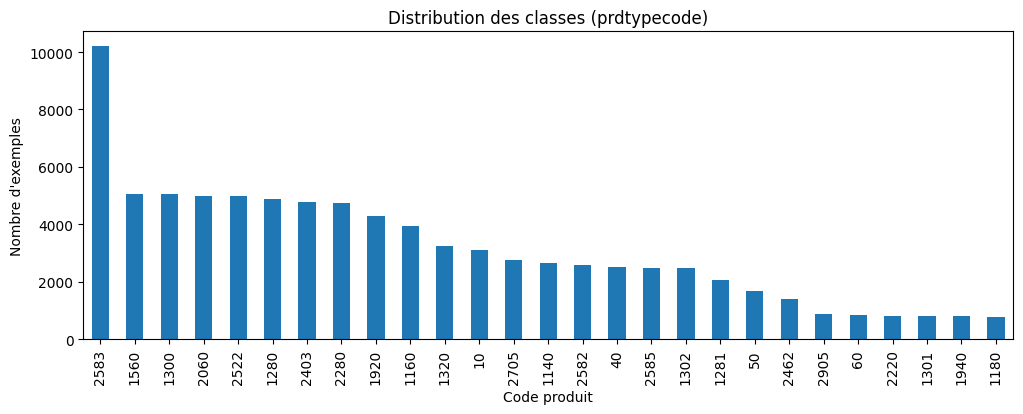

In [9]:
# Distribution de la cible
df_train["prdtypecode"].value_counts().plot(kind="bar", figsize=(12,4))
plt.title("Distribution des classes (prdtypecode)")
plt.xlabel("Code produit")
plt.ylabel("Nombre d'exemples")
plt.show()

## Vérification des chemins d'images

In [10]:
image_folder = "rakuten_data/nlp_dl_images/image_train/image_train"

# Générer le nom de fichier image
df_train["image_filename"] = df_train.apply(
    lambda row: f"image_{row['imageid']}_product_{row['productid']}.jpg", axis=1)

# Chemin complet
from pathlib import Path
df_train["image_path"] = df_train["image_filename"].apply(lambda x: os.path.join(image_folder, x))
df_train["image_exists"] = df_train["image_path"].apply(lambda path: Path(path).exists())

print("✅ Images trouvées :", df_train["image_exists"].sum())
print("❌ Images manquantes :", (~df_train["image_exists"]).sum())

✅ Images trouvées : 84916
❌ Images manquantes : 0


🔹 designation: Grand Stylet Ergonomique Bleu Gamepad Nintendo Wii U - Speedlink Pilot Style
🔹 description: PILOT STYLE Touch Pen de marque Speedlink est 1 stylet ergonomique pour GamePad Nintendo Wii U.<br> Pour un confort optimal et une précision maximale sur le GamePad de la Wii U: ce grand stylet hautement ergonomique est non seulement parfaitement adapté à votre main mais aussi très élégant.<br> Il est livré avec un support qui se fixe sans adhésif à l'arrière du GamePad<br> <br> Caractéristiques:<br> Modèle: Speedlink PILOT STYLE Touch Pen<br> Couleur: Bleu<br> Ref. Fabricant: SL-3468-BE<br> Compatibilité: GamePad Nintendo Wii U<br> Forme particulièrement ergonomique excellente tenue en main<br> Pointe à revêtement longue durée conçue pour ne pas abîmer l'écran tactile<br> En bonus : Support inclu pour GamePad<br> <span class="vga_style2"><b></b><br>
🔹 prdtypecode: 50


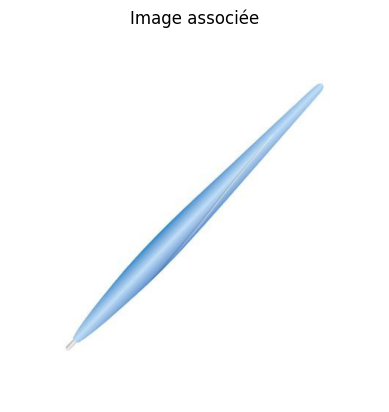

In [11]:
## exemple :

def show_example(row_index):
    row = df_train.iloc[row_index]
    print("🔹 designation:", row["designation"])
    print("🔹 description:", row["description"])
    print("🔹 prdtypecode:", row["prdtypecode"])

    if row["image_exists"]:
        img = Image.open(row["image_path"])
        plt.imshow(img)
        plt.axis("off")
        plt.title("Image associée")
        plt.show()
    else:
        print("Image non trouvée !")

example_index = df_train[df_train["image_exists"]].index[2]
show_example(example_index)

In [12]:
## Fusion des deux colonnes pour avoir plus de textes
df_train["full_text"] = df_train["designation"].fillna("") + " " + df_train["description"].fillna("")
df_train.head(2)

,designation,description,productid,imageid,prdtypecode,image_filename,image_path,image_exists,full_text
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,10,image_1263597046_product_3804725264.jpg,rakuten_data/nlp_dl_images/image_train/image_t...,True,Olivia: Personalisiertes Notizbuch / 150 Seite...
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,2280,image_1008141237_product_436067568.jpg,rakuten_data/nlp_dl_images/image_train/image_t...,True,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...


## Analyse exploratoire des données textuelles

In [13]:
# Analyse de la longueur des textes
df_train["designation_length"] = df_train["designation"].fillna("").apply(len)
df_train["description_length"] = df_train["description"].fillna("").apply(len)
df_train["full_text_length"] = df_train["full_text"].apply(len)

# Statistiques sur les longueurs
print("Statistiques sur la longueur des textes:")
print(df_train[["designation_length", "description_length", "full_text_length"]].describe())

Statistiques sur la longueur des textes:
       designation_length  description_length  full_text_length
count        84916.000000        84916.000000      84916.000000
mean            70.163303          524.555926        595.719228
std             36.793383          754.893905        762.067621
min             11.000000            0.000000         12.000000
25%             43.000000            0.000000         66.000000
50%             64.000000          231.000000        314.000000
75%             90.000000          823.000000        904.000000
max            250.000000        12451.000000      12536.000000


* Les désignations sont relativement courtes (moyenne de 70 caractères)
* Les descriptions sont beaucoup plus longues (moyenne de 524 caractères) mais très variables (écart-type élevé de 754)
* Il y a des descriptions très longues (max 12451 caractères)
* 25% des données n'ont pas de description (valeur 0 au 25e percentile)

In [14]:
# Analyse des valeurs manquantes
missing_values = pd.DataFrame({
    'designation_missing': df_train['designation'].isna().sum(),
    'description_missing': df_train['description'].isna().sum(),
    'both_missing': (df_train['designation'].isna() & df_train['description'].isna()).sum()
}, index=['count'])

missing_percentages = pd.DataFrame({
    'designation_missing_%': df_train['designation'].isna().mean() * 100,
    'description_missing_%': df_train['description'].isna().mean() * 100,
    'both_missing_%': (df_train['designation'].isna() & df_train['description'].isna()).mean() * 100
}, index=['percentage'])

print("Valeurs manquantes:")
pd.concat([missing_values, missing_percentages])

Valeurs manquantes:


,designation_missing,description_missing,both_missing,designation_missing_%,description_missing_%,both_missing_%
count,0.0,29800.0,0.0,NaN,NaN,NaN
percentage,NaN,NaN,NaN,0.0,35.093504,0.0


* Aucune désignation manquante (0%)
* 35% des descriptions sont manquantes
* Aucun produit n'a à la fois une désignation et une description manquantes

## Nettoyage du texte

In [15]:
stop_words = set(stopwords.words('french')).union(set(stopwords.words('english')))

def clean_text(text):
    if not isinstance(text, str):
        return ""

    # Votre nettoyage actuel
    text = re.sub('<[^<]+?>', ' ', text)
    text = re.sub('&[a-z]+;', ' ', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    text = re.sub(r'\d+', ' ', text)
    text = text.lower()

    # Suppression des stopwords
    words = text.split()
    words = [w for w in words if w not in stop_words]
    text = ' '.join(words)

    # Suppression des espaces multiples
    text = re.sub(r'\s+', ' ', text)

    return text.strip()

# Réappliquez ce nettoyage
df_train["clean_text"] = df_train["full_text"].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


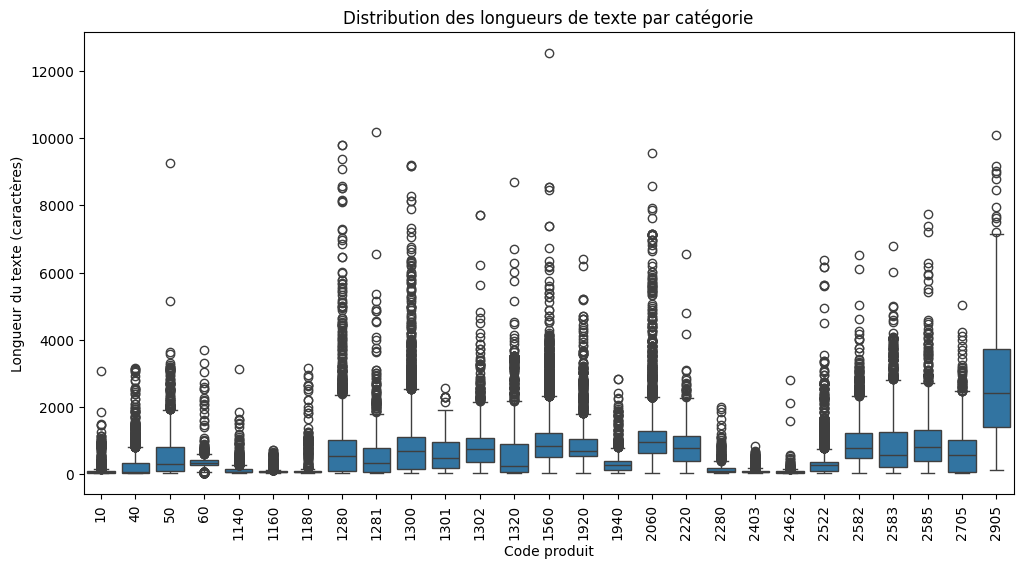

In [16]:
# Visualiser la distribution des longueurs de texte par catégorie
plt.figure(figsize=(12, 6))
sns.boxplot(x="prdtypecode", y="full_text_length", data=df_train.sort_values("prdtypecode"))
plt.title("Distribution des longueurs de texte par catégorie")
plt.xlabel("Code produit")
plt.ylabel("Longueur du texte (caractères)")
plt.xticks(rotation=90)
plt.show()

In [17]:
df_train.head(2)

,designation,description,productid,imageid,prdtypecode,image_filename,image_path,image_exists,full_text,designation_length,description_length,full_text_length,clean_text
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,10,image_1263597046_product_3804725264.jpg,rakuten_data/nlp_dl_images/image_train/image_t...,True,Olivia: Personalisiertes Notizbuch / 150 Seite...,88,0,89,olivia personalisiertes notizbuch seiten punkt...
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,2280,image_1008141237_product_436067568.jpg,rakuten_data/nlp_dl_images/image_train/image_t...,True,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,206,0,207,journal arts art marche salon art asiatique pa...


## MODELISATION TEXTE

* Les catégories ont des profils textuels très différents
* La catégorie 2905 semble avoir des descriptions beaucoup plus longues en moyenne
* Certaines catégories (10, 1140, 1160, 2403, 2462) ont des textes généralement très courts
* On observe beaucoup de valeurs aberrantes (outliers) dans presque toutes les catégories

In [18]:
# Encoder la cible
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df_train["prdtypecode"])

# Séparation en ensembles d'entraînement et de validation
X_text = df_train["clean_text"]
y = y_encoded

X_train_text, X_val_text, y_train, y_val = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Taille de l'ensemble d'entraînement: {X_train_text.shape[0]}")
print(f"Taille de l'ensemble de validation: {X_val_text.shape[0]}")

Taille de l'ensemble d'entraînement: 67932
Taille de l'ensemble de validation: 16984


## Première Approche: TF-IDF + regression logistique

In [19]:
# Vectorisation TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

print("Vectorisation des textes avec TF-IDF...")
# Créer le vectoriseur TF-IDF
vectorizer = TfidfVectorizer(
    max_features=10000,  # Limite le vocabulaire aux 10 000 termes les plus fréquents
    ngram_range=(1, 2),  # Inclure les unigrammes et bigrammes
    min_df=5,            # Ignorer les termes qui apparaissent dans moins de 5 documents
    max_df=0.8           # Ignorer les termes qui apparaissent dans plus de 80% des documents
)

# Transformer les textes en vecteurs TF-IDF
X_train_tfidf = vectorizer.fit_transform(X_train_text)
X_val_tfidf = vectorizer.transform(X_val_text)

print(f"Dimensions de X_train_tfidf: {X_train_tfidf.shape}")
print(f"Dimensions de X_val_tfidf: {X_val_tfidf.shape}")

Vectorisation des textes avec TF-IDF...
Dimensions de X_train_tfidf: (67932, 10000)
Dimensions de X_val_tfidf: (16984, 10000)


In [20]:
print("Entraînement du modèle de régression logistique...")
# Créer et entraîner le modèle
model = LogisticRegression(
    C=1.0,
    max_iter=1000,
    solver='saga',
    multi_class='multinomial',
    n_jobs=-1
)

model.fit(X_train_tfidf, y_train)

# Évaluation du modèle
print("Évaluation du modèle...")
# Prédictions sur l'ensemble de validation
y_pred = model.predict(X_val_tfidf)

# Calcul des métriques
accuracy = accuracy_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred, average='weighted')
print(f"Score F1 pondéré: {f1:.4f}")

# Rapport de classification
print("\nRapport de classification:")
print(classification_report(y_val, y_pred))

Entraînement du modèle de régression logistique...


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Évaluation du modèle...
Score F1 pondéré: 0.7829

Rapport de classification:
              precision    recall  f1-score   support

           0       0.35      0.53      0.43       623
           1       0.71      0.57      0.63       502
           2       0.78      0.78      0.78       336
           3       0.95      0.74      0.83       166
           4       0.77      0.75      0.76       534
           5       0.90      0.88      0.89       791
           6       0.79      0.46      0.58       153
           7       0.67      0.60      0.63       974
           8       0.65      0.47      0.54       414
           9       0.84      0.91      0.87      1009
          10       0.97      0.91      0.94       161
          11       0.81      0.71      0.75       498
          12       0.77      0.74      0.75       648
          13       0.81      0.83      0.82      1015
          14       0.89      0.91      0.90       861
          15       0.92      0.80      0.86       161
    

## Deuxième Approche : CNN multichannel

In [26]:
# Paramètres
max_words = 50000
max_length = 300  # A ajuster selon vos données
embedding_dim = 300
batch_size = 32  # Réduit pour une meilleure généralisation
epochs = 10  # Augmenté mais avec early stopping


# Tokenization
tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_text)
X_train_seq = tokenizer.texts_to_sequences(X_train_text)
X_val_seq = tokenizer.texts_to_sequences(X_val_text)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post', truncating='post')

# One-hot encoding de la cible pour le modèle Keras
num_classes = len(label_encoder.classes_)
y_train_cat = to_categorical(y_train, num_classes)
y_val_cat = to_categorical(y_val, num_classes)

# Créer le modèle CNN amélioré - approche multichannel
input_layer = tf.keras.layers.Input(shape=(max_length,))

# Sans embeddings pré-entraînés
embedding = tf.keras.layers.Embedding(max_words, embedding_dim)(input_layer)

# Batch normalization après l'embedding
embedding_bn = tf.keras.layers.BatchNormalization()(embedding)
reshape = tf.keras.layers.Reshape((max_length, embedding_dim, 1))(embedding_bn)

# Utiliser des filtres de différentes tailles sur la même entrée
conv_blocks = []
# Filtres de différentes tailles - ajout d'un filtre plus petit
filter_sizes = [2, 3, 4, 5]
for filter_size in filter_sizes:
    # Convolution 2D avec régularisation L2
    conv = tf.keras.layers.Conv2D(
        128, (filter_size, embedding_dim),
        activation='relu',
        kernel_regularizer=l2(0.001)
    )(reshape)
    # Batch Normalization
    conv_bn = tf.keras.layers.BatchNormalization()(conv)
    # Global Max Pooling
    pool = tf.keras.layers.GlobalMaxPooling2D()(conv_bn)
    conv_blocks.append(pool)

# Concaténer les résultats des différents filtres
concatenated = tf.keras.layers.Concatenate()(conv_blocks)

# Double couche de dropout pour une meilleure régularisation
dropout1 = tf.keras.layers.Dropout(0.5)(concatenated)
dense = tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001))(dropout1)
bn_dense = tf.keras.layers.BatchNormalization()(dense)
dropout2 = tf.keras.layers.Dropout(0.5)(bn_dense)

# Couche de sortie
output = tf.keras.layers.Dense(num_classes, activation='softmax', kernel_regularizer=l2(0.001))(dropout2)

# Créer le modèle
model_cnn = tf.keras.Model(inputs=input_layer, outputs=output)

# Compiler avec un learning rate légèrement réduit
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
model_cnn.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Afficher le résumé du modèle
model_cnn.summary()

# Callbacks pour limiter l'overfitting
callbacks = [
    # Arrêter l'entraînement si la performance ne s'améliore pas
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    # Réduire le learning rate si on plafonne
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )
]

# Calculer les poids des classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convertir en dictionnaire
class_weight_dict = dict(zip(np.unique(y_train), class_weights))

# Entraîner avec la pondération des classes
history = model_cnn.fit(
    X_train_pad, y_train_cat,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val_pad, y_val_cat),
    callbacks=callbacks,
    class_weight=class_weight_dict,
    verbose=1
)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 300, 300)  │ 15,000,000 │ input_layer_2[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 300, 300)  │      1,200 │ embedding_2[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 300, 300,  │          0 │ batch_normalizat… │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 299, 1,    │     76,928 │ reshape_2[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 298, 1,    │    115,328 │ reshape_2[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 297, 1,    │    153,728 │ reshape_2[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 296, 1,    │    192,128 │ reshape_2[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 299, 1,    │        512 │ conv2d_8[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 298, 1,    │        512 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 297, 1,    │        512 │ conv2d_10[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 296, 1,    │        512 │ conv2d_11[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ batch_normalizat… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 512)       │          0 │ global_max_pooli

 Total params: 15,680,651 (59.82 MB)

 Trainable params: 15,678,515 (59.81 MB)

 Non-trainable params: 2,136 (8.34 KB)

Epoch 1/10
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 71s 29ms/step - accuracy: 0.2866 - loss: 3.2255 - val_accuracy: 0.7481 - val_loss: 1.2977 - learning_rate: 5.0000e-04
Epoch 2/10
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 66s 24ms/step - accuracy: 0.7224 - loss: 1.3640 - val_accuracy: 0.7978 - val_loss: 1.0869 - learning_rate: 5.0000e-04
Epoch 3/10
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 84s 25ms/step - accuracy: 0.8122 - loss: 1.0217 - val_accuracy: 0.8009 - val_loss: 1.0866 - learning_rate: 5.0000e-04
Epoch 4/10
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 81s 24ms/step - accuracy: 0.8543 - loss: 0.8938 - val_accuracy: 0.8141 - val_loss: 1.0615 - learning_rate: 5.0000e-04
Epoch 5/10
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 81s 24ms/step - accuracy: 0.8788 - loss: 0.8082 - val_accuracy: 0.8107 - val_loss: 1.0656 - learning_rate: 5.0000e-04
Epoch 6/10
2121/2123 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8938 - loss: 0.7558
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
2123/2123 ━━━━━━━━━━━━━━━━━━━━ 83s 

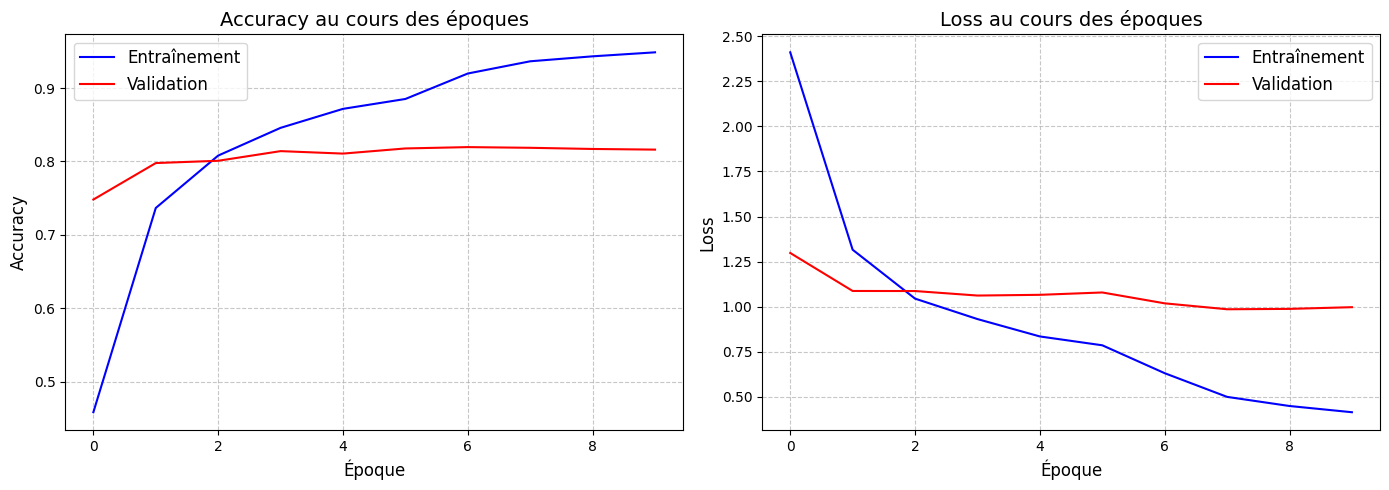

In [31]:
plt.figure(figsize=(14, 5))

# Courbe d'accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], 'b-', label='Entraînement')
plt.plot(history.history['val_accuracy'], 'r-', label='Validation')
plt.title('Accuracy au cours des époques', fontsize=14)
plt.xlabel('Époque', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

# Courbe de loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'b-', label='Entraînement')
plt.plot(history.history['val_loss'], 'r-', label='Validation')
plt.title('Loss au cours des époques', fontsize=14)
plt.xlabel('Époque', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)

plt.tight_layout()
plt.show()

In [ ]:
# VALIDATION
y_pred_proba = model_cnn.predict(X_val_pad)
y_pred_cnn = np.argmax(y_pred_proba, axis=1)
f1_cnn = f1_score(y_val, y_pred_cnn, average='weighted')
accuracy = np.mean(np.argmax(y_val_cat, axis=1) == y_pred_cnn)

print(f"F1-score pondéré CNN: {f1_cnn:.4f}")
print(f"Précision sur la validation: {accuracy:.4f}")

from sklearn.metrics import classification_report

print("\nRapport de classification:")
print(classification_report(y_val, y_pred_cnn))

531/531 ━━━━━━━━━━━━━━━━━━━━ 164s 307ms/step
F1-score pondéré CNN: 0.8252
Précision sur la validation: 0.8254

Rapport de classification:
              precision    recall  f1-score   support

           0       0.48      0.50      0.49       623
           1       0.73      0.72      0.73       502
           2       0.82      0.83      0.82       336
           3       0.99      0.75      0.86       166
           4       0.73      0.77      0.75       534
           5       0.96      0.93      0.94       791
           6       0.76      0.50      0.60       153
           7       0.73      0.78      0.75       974
           8       0.72      0.55      0.62       414
           9       0.95      0.95      0.95      1009
          10       0.97      0.96      0.97       161
          11       0.86      0.78      0.82       498
          12       0.83      0.84      0.83       648
          13       0.87      0.85      0.86      1015
          14       0.90      0.95      0.92       8

In [32]:
# Sauvegarder le modèle
model_cnn.save('/content/drive/MyDrive/NLP_DL_Project/mon_modele_cnn.h5')

# Sauvegarder le tokenizer
import pickle
with open('/content/drive/MyDrive/NLP_DL_Project/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [33]:
# des exemples mal prédits
incorrect_indices = np.where(y_pred_cnn != y_val)[0]

incorrect_examples = []
for idx in incorrect_indices:
    # Récupérer le texte original
    original_text = X_val_text.iloc[idx] if hasattr(X_val_text, 'iloc') else X_val_text[idx]

    # Récupérer la classe réelle et prédite
    true_label = label_encoder.inverse_transform([y_val[idx]])[0]
    pred_label = label_encoder.inverse_transform([y_pred_cnn[idx]])[0]

    # Récupérer la confiance de prédiction
    confidence = np.max(y_pred_proba[idx])

    incorrect_examples.append({
        'texte': original_text,
        'vraie_classe': true_label,
        'classe_predite': pred_label,
        'confiance': confidence
    })

errors_df = pd.DataFrame(incorrect_examples)

print(f"Nombre total d'exemples mal prédits: {len(errors_df)}")
print(f"Taux d'erreur: {len(errors_df) / len(y_val):.2%}")

# Afficher quelques exemples d'erreurs avec une forte confiance
print("\n--- Exemples d'erreurs avec forte confiance ---")
high_conf_errors = errors_df.sort_values('confiance', ascending=False).head(5)
for i, row in high_conf_errors.iterrows():
    print(f"Exemple {i+1}:")
    print(f"Texte: {row['texte'][:150]}..." if len(str(row['texte'])) > 150 else f"Texte: {row['texte']}")
    print(f"Vraie classe: {row['vraie_classe']}")
    print(f"Classe prédite: {row['classe_predite']}")
    print(f"Confiance: {row['confiance']:.2%}")
    print("-" * 80)

# Afficher les erreurs les plus fréquentes par paire de classes
print("\n--- Paires de confusion les plus fréquentes ---")
confusion_pairs = errors_df.groupby(['vraie_classe', 'classe_predite']).size().reset_index(name='count')
top_confusion_pairs = confusion_pairs.sort_values('count', ascending=False).head(10)
print(top_confusion_pairs)

# Visualiser les erreurs pour les classes les plus problématiques
print("\n--- Classes avec le plus d'erreurs ---")
class_error_counts = errors_df['vraie_classe'].value_counts().reset_index()
class_error_counts.columns = ['classe', 'nombre_erreurs']
print(class_error_counts.head(10))

# Analyser les erreurs par longueur de texte
errors_df['longueur_texte'] = errors_df['texte'].astype(str).apply(len)
print("\n--- Statistiques sur la longueur des textes mal prédits ---")
print(f"Longueur moyenne des textes mal prédits: {errors_df['longueur_texte'].mean():.1f} caractères")
print(f"Longueur médiane des textes mal prédits: {errors_df['longueur_texte'].median():.1f} caractères")
print(f"Longueur minimale: {errors_df['longueur_texte'].min()} caractères")
print(f"Longueur maximale: {errors_df['longueur_texte'].max()} caractères")

Nombre total d'exemples mal prédits: 3081
Taux d'erreur: 18.14%

--- Exemples d'erreurs avec forte confiance ---
Exemple 375:
Texte: dragées petits coeurs argents chocolat g saveur couleur mots correspondent mieux cette gourmandise couleur argentée composée chocolat cacao finement e...
Vraie classe: 2060
Classe prédite: 1940
Confiance: 100.00%
--------------------------------------------------------------------------------
Exemple 458:
Texte: salade cuisson cuisine silicone service tenailles barbecue poignée acier inoxydable ustensile silicone kitchen cooking salad serving bbq tongs stainle...
Vraie classe: 2060
Classe prédite: 2582
Confiance: 100.00%
--------------------------------------------------------------------------------
Exemple 2544:
Texte: piscine boudins fond gonflable piscine boudins rose vert jaune fond gonflable dimensions ø x h cm
Vraie classe: 1302
Classe prédite: 2583
Confiance: 100.00%
--------------------------------------------------------------------------------


* Taux d'erreur global : 18,14% des exemples de validation sont mal prédits, ce qui correspond à votre précision de validation d'environ 82%.
* Erreurs à haute confiance : Certaines erreurs sont particulièrement préoccupantes car le modèle est extrêmement confiant (100%) alors qu'il se trompe.


* Paires de confusion fréquentes : classes sont systématiquement confondues, suggérant qu'elles partagent peut-être des caractéristiques textuelles similaires

Classes 1280/1281 : 109 erreurs
Classes 2403/10 : 107 erreurs
Classes 2403/2280 : 97 erreurs

* Classes problématiques : La classe 10 est impliquée dans le plus grand nombre d'erreurs (308). Les classes 1280, 2403 et 2280 sont également très souvent mal prédites


* Longueur des textes : Grande variabilité dans la longueur des textes mal prédits (0 à 7780 caractères). La longueur médiane des textes mal prédits est de 61 caractères, ce qui est relativement court. Certains textes vides ou très courts sont difficiles à classifier correctement